#Spotify Skip Prediction 

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
# importing essential libraries and modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
 
from imblearn.over_sampling import SMOTE
 
from sklearn.model_selection import  train_test_split
 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

## Analysing Training Set :

In [58]:
# load training set 
train = pd.read_csv("/content/drive/MyDrive/Spotify/data/training_set/log_mini.csv")
train.shape

(167880, 21)

- It has 167880 rows and 21 attributes 

In [60]:
train.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


In [61]:
# Information of training set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167880 entries, 0 to 167879
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   session_id                       167880 non-null  object
 1   session_position                 167880 non-null  int64 
 2   session_length                   167880 non-null  int64 
 3   track_id_clean                   167880 non-null  object
 4   skip_1                           167880 non-null  bool  
 5   skip_2                           167880 non-null  bool  
 6   skip_3                           167880 non-null  bool  
 7   not_skipped                      167880 non-null  bool  
 8   context_switch                   167880 non-null  int64 
 9   no_pause_before_play             167880 non-null  int64 
 10  short_pause_before_play          167880 non-null  int64 
 11  long_pause_before_play           167880 non-null  int64 
 12  hist_user_behavi

 
- As from the data we can see, skip_1, skip_2 and some more coulmns are in  boolean(True or False) but it is counting as object so in pre-processing step we weill change the datatype 
- There are many null values 

### Statistical summary 

In [62]:
train.describe()

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hour_of_day
count,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000,167880.000000
mean,9.325911,17.651823,0.040904,0.767602,0.146635,0.172832,0.038909,0.046259,14.193084
std,5.457638,3.422025,0.198069,0.422363,0.353742,0.378103,0.367295,0.606558,5.996243
min,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,15.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.000000
50%,9.000000,20.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,15.000000
75%,14.000000,20.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,19.000000
max,20.000000,20.000000,1.000000,1.000000,1.000000,1.000000,60.000000,151.000000,23.000000


In [63]:
# summary for objects columns
train.describe(include=['O'])

,session_id,track_id_clean,date,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
count,167880,167880,167880,167880,167880,167880
unique,10000,50704,18,6,9,7
top,0_022c0fa1-0e35-4ccc-a722-549b2c4d1197,t_bacf06d3-9185-4183-84ea-ff0db51475ce,2018-07-15,user_collection,fwdbtn,fwdbtn
freq,20,1427,119639,67430,79912,81389


### Data-preprocessing and EDA

In [64]:
# droping duplicates and null values : 
train.drop_duplicates(inplace=True)
train.dropna(inplace=True)
train.shape

(167880, 21)

In [65]:
# changing the type of columns 
for colname in ['skip_1','skip_2','skip_3','not_skipped','hist_user_behavior_is_shuffle','premium']:
    train[colname] = train[colname].astype(int, copy=False)

### Creating target column

In [66]:
train['skip'] = train['not_skipped'].replace({ 0 : 1, 1 : 0 })

In [67]:
train['skip'].value_counts()

1    111996
0     55884
Name: skip, dtype: int64

### Analysing categorical data

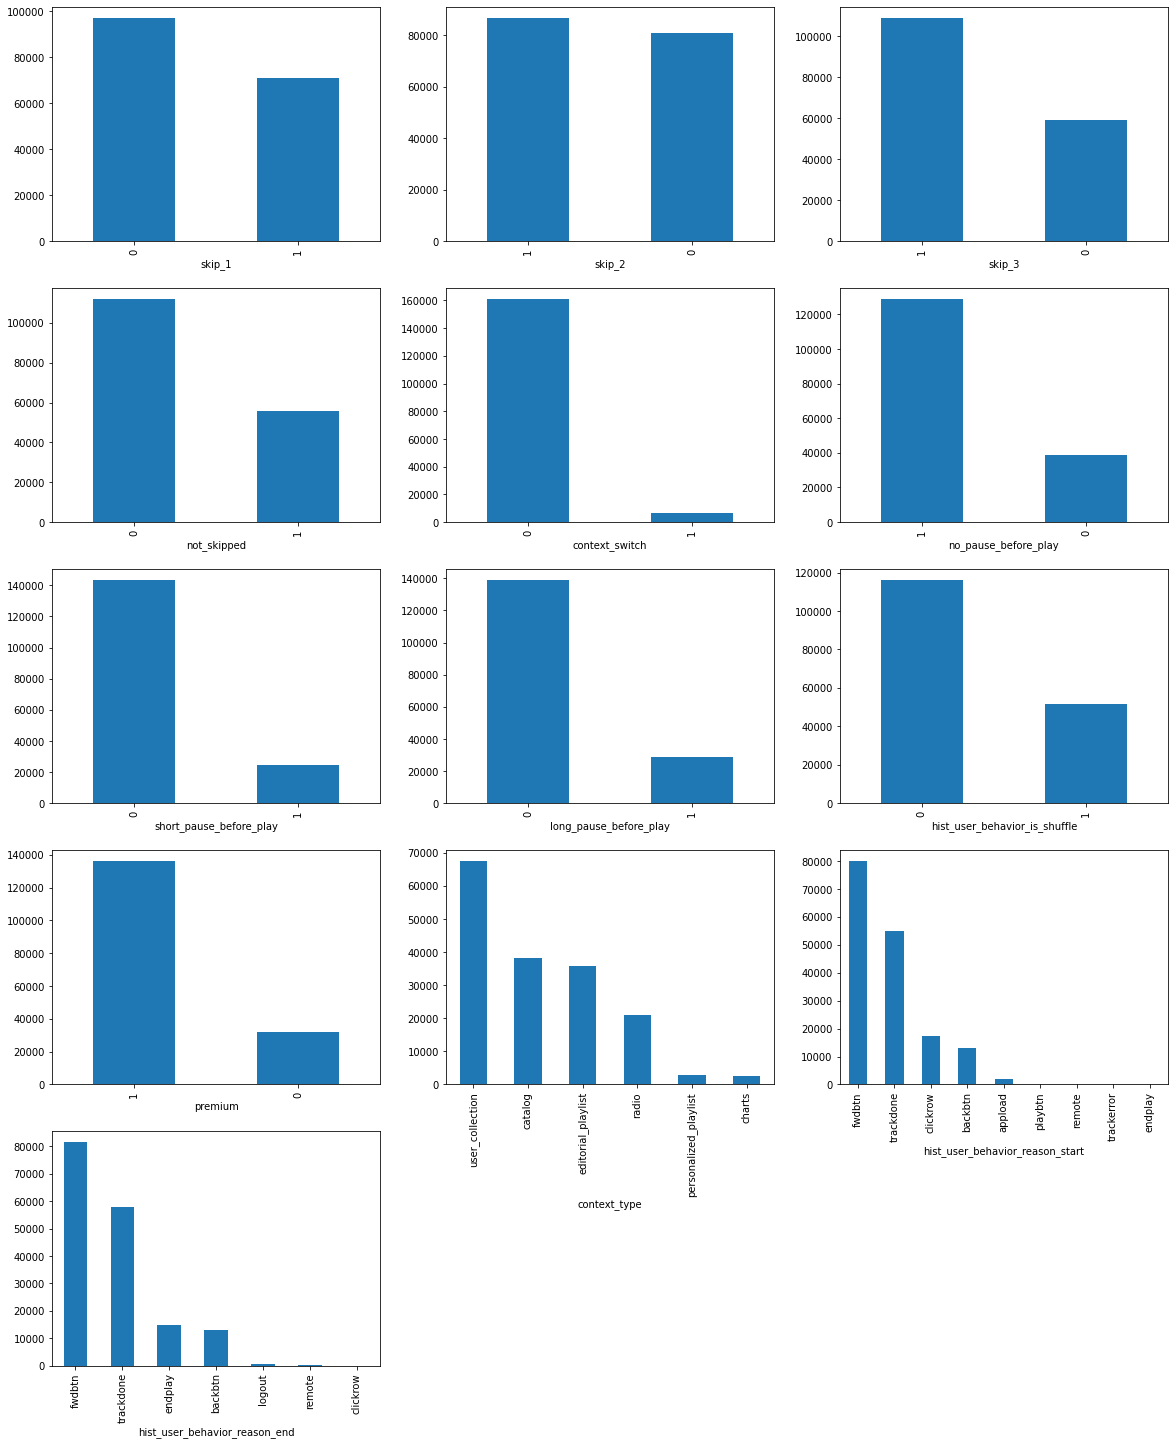

In [69]:
col = ['skip_1','skip_2','skip_3',
       'not_skipped','context_switch','no_pause_before_play',
       'short_pause_before_play','long_pause_before_play','hist_user_behavior_is_shuffle',
       'premium','context_type','hist_user_behavior_reason_start',
       'hist_user_behavior_reason_end']

plt.figure(figsize=(20,25))
n = 1
for colname in col:
    plt.subplot(5,3,n)
    train[colname].value_counts().plot(kind='bar')
    plt.xlabel(colname)
    n +=1

In [70]:
# creating copy of the train data 
df = train.copy()
df.shape

(167880, 22)

In [71]:
# df.date = df.date.apply(pd.to_datetime)
# df.info()

### Dropping Irrelevent columns

In [72]:
df = df.drop(columns=['skip_1','skip_2','skip_3','not_skipped','date'])
df.shape

(167880, 17)

In [73]:
df.head()

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,skip
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,1,16,1,editorial_playlist,trackdone,trackdone,0
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,0,1,0,0,0,0,1,16,1,editorial_playlist,trackdone,trackdone,0
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,0,1,0,0,0,0,1,16,1,editorial_playlist,trackdone,trackdone,0
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,0,1,0,0,0,0,1,16,1,editorial_playlist,trackdone,trackdone,0
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,0,1,0,0,0,0,1,16,1,editorial_playlist,trackdone,trackdone,0


### One-hot Encoding on Train data

In [74]:
df1 = df.drop(['session_id', 'track_id_clean'], axis=1)
df1.shape

(167880, 15)

In [75]:
dummy_train = pd.get_dummies(df1)
dummy_train.shape

(167880, 34)

In [76]:
dummy_train.head()

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,premium,skip,context_type_catalog,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_end_backbtn,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone
0,1,20,0,0,0,0,0,0,1,16,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,2,20,0,1,0,0,0,0,1,16,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,3,20,0,1,0,0,0,0,1,16,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,4,20,0,1,0,0,0,0,1,16,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,5,20,0,1,0,0,0,0,1,16,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


## Analysing Track Features 

In [77]:
# there are two different files of track features so the aim is to merge both of them then analyse data: 
tf = pd.read_csv('/content/drive/MyDrive/Spotify/data/track_features/tf_mini.csv')
tf.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,0.903753,3.254327e-06,0,0.132124,-11.238,0.386100,major,0.541606,0.079985,166.287003,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,1.037952,8.344854e-12,0,0.163281,-13.706,0.125000,major,0.895874,0.083877,95.261002,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,1.004268,2.927475e-10,0,0.090115,-10.522,0.200669,minor,0.806136,0.038777,105.185997,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496
3,t_070a63a0-744a-434e-9913-a97b02926a29,175.399994,1951,99.665018,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,0.975138,3.981341e-11,0,0.360924,-11.032,0.427152,major,0.492772,0.038337,119.441002,4,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.600006,1951,99.991764,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,0.976866,2.541884e-10,0,0.189162,-6.836,0.281250,major,0.723808,0.032043,95.261002,4,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496


In [78]:
tf2 = pd.read_csv('/content/drive/MyDrive/Spotify/data/track_features/tf_mini.csv')
tf2.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,0.903753,3.254327e-06,0,0.132124,-11.238,0.386100,major,0.541606,0.079985,166.287003,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,1.037952,8.344854e-12,0,0.163281,-13.706,0.125000,major,0.895874,0.083877,95.261002,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,1.004268,2.927475e-10,0,0.090115,-10.522,0.200669,minor,0.806136,0.038777,105.185997,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496
3,t_070a63a0-744a-434e-9913-a97b02926a29,175.399994,1951,99.665018,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,0.975138,3.981341e-11,0,0.360924,-11.032,0.427152,major,0.492772,0.038337,119.441002,4,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.600006,1951,99.991764,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,0.976866,2.541884e-10,0,0.189162,-6.836,0.281250,major,0.723808,0.032043,95.261002,4,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496


In [79]:
# joining two dataframes : 
track = pd.concat([tf, tf2])
track.shape

(101408, 30)

In [80]:
track.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101408 entries, 0 to 50703
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   track_id                101408 non-null  object 
 1   duration                101408 non-null  float64
 2   release_year            101408 non-null  int64  
 3   us_popularity_estimate  101408 non-null  float64
 4   acousticness            101408 non-null  float64
 5   beat_strength           101408 non-null  float64
 6   bounciness              101408 non-null  float64
 7   danceability            101408 non-null  float64
 8   dyn_range_mean          101408 non-null  float64
 9   energy                  101408 non-null  float64
 10  flatness                101408 non-null  float64
 11  instrumentalness        101408 non-null  float64
 12  key                     101408 non-null  int64  
 13  liveness                101408 non-null  float64
 14  loudness             

In [81]:
track.duplicated().sum()

50704

In [82]:
track.isna().sum()

track_id                  0
duration                  0
release_year              0
us_popularity_estimate    0
acousticness              0
beat_strength             0
bounciness                0
danceability              0
dyn_range_mean            0
energy                    0
flatness                  0
instrumentalness          0
key                       0
liveness                  0
loudness                  0
mechanism                 0
mode                      0
organism                  0
speechiness               0
tempo                     0
time_signature            0
valence                   0
acoustic_vector_0         0
acoustic_vector_1         0
acoustic_vector_2         0
acoustic_vector_3         0
acoustic_vector_4         0
acoustic_vector_5         0
acoustic_vector_6         0
acoustic_vector_7         0
dtype: int64

### Statistical summary of track features

In [83]:
track.describe()

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
count,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,1.014080e+05,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000,101408.000000
mean,222.267980,2010.324748,99.455131,0.250336,0.492075,0.514526,0.611742,8.215950,0.641440,0.996548,7.058671e-02,5.269111,0.205520,-7.519316,0.547603,0.391874,0.122998,121.576396,3.913163,0.487804,-0.332295,0.202193,0.153935,-0.040526,-0.027247,0.049475,-0.197758,0.005153
std,72.224483,11.471809,1.139216,0.276046,0.158102,0.182594,0.166145,2.410614,0.207956,0.045611,2.142251e-01,3.597560,0.176485,3.927838,0.223801,0.207115,0.136021,29.786594,0.410034,0.246375,0.416318,0.254022,0.212658,0.333127,0.377455,0.144204,0.349838,0.324258
min,30.013330,1950.000000,90.018900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.122792,-1.084360,-0.752231,-0.809136,-1.029858,-0.942461,-0.736395,-0.975647
25%,183.933334,2009.000000,99.509670,0.025291,0.374378,0.372463,0.502499,6.356671,0.507839,0.975910,1.084167e-08,2.000000,0.098249,-8.942000,0.366652,0.225742,0.038028,97.158997,4.000000,0.292559,-0.745148,0.086460,0.051604,-0.294574,-0.318751,-0.038337,-0.444849,-0.176821
50%,214.866669,2015.000000,99.865444,0.135821,0.493764,0.522266,0.625145,8.015075,0.661368,1.003790,2.211650e-06,5.000000,0.131403,-6.688000,0.571023,0.364057,0.061794,120.115498,4.000000,0.478244,-0.334799,0.265535,0.207705,-0.001755,-0.176974,0.062719,-0.298599,0.090423
75%,250.426666,2017.000000,99.961131,0.406142,0.604994,0.655912,0.736241,9.792092,0.803185,1.026137,7.654784e-04,8.000000,0.262823,-5.043000,0.729537,0.533131,0.160202,141.014008,4.000000,0.677947,0.045921,0.359553,0.296132,0.146828,0.280852,0.160366,-0.075158,0.194285
max,1787.760986,2018.000000,99.999997,0.995796,0.990419,0.972590,0.984952,32.342781,0.999877,1.103213,9.993988e-01,11.000000,0.996257,1.634000,1.000000,0.962350,0.961408,218.774994,5.000000,0.999990,0.932165,0.812837,0.605288,1.074504,0.895769,0.380279,0.966760,1.152213


In [84]:
# summary for object columns:
track.describe(include='O')

,track_id,mode
count,101408,101408
unique,50704,2
top,t_de63126b-07be-4cc5-be4e-3fca17f0ef5f,major
freq,2,65110


### EDA 

In [85]:
# extracting columns other than float ie, int and object for eda :
tf[[c for c in tf.columns if tf[c].dtype != 'float64']].head()

,track_id,release_year,key,mode,time_signature
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,1950,0,major,4
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,1950,0,major,3
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,1951,0,minor,4
3,t_070a63a0-744a-434e-9913-a97b02926a29,1951,0,major,4
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,1951,0,major,4


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


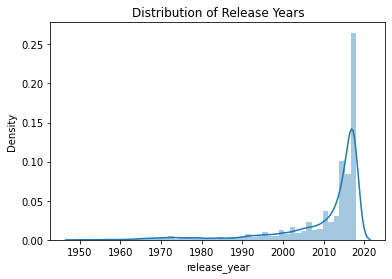

In [86]:
# distribution of release years : 
sns.distplot(track.release_year)
plt.title("Distribution of Release Years");

In [87]:
track['key'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [88]:
track['mode'].value_counts()

major    65110
minor    36298
Name: mode, dtype: int64

In [89]:
# creating label encoding/one hot encoding of mode column 
track['mode'] = track['mode'].replace({
    'major': 1,
    'minor': 0
})

### Analysing numerical columns

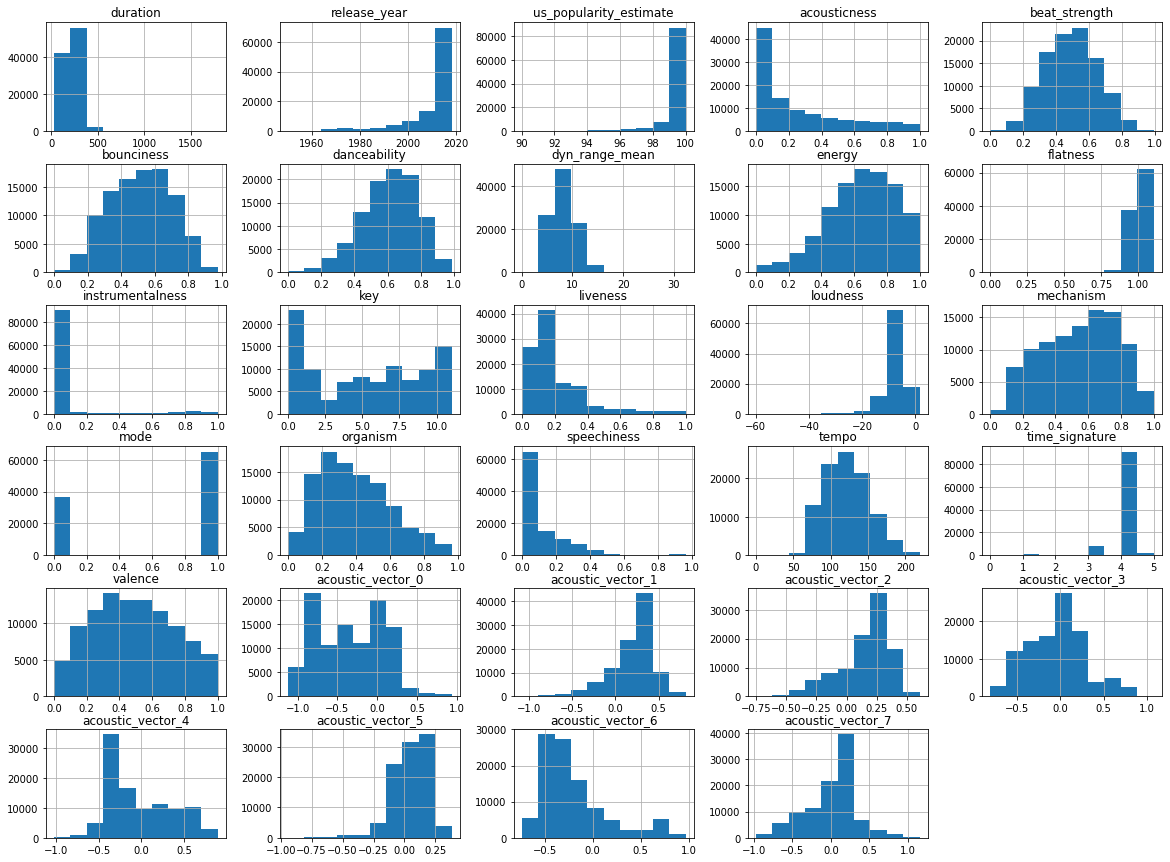

In [90]:
track.hist(figsize=(20,15));

### Correlation matrix  

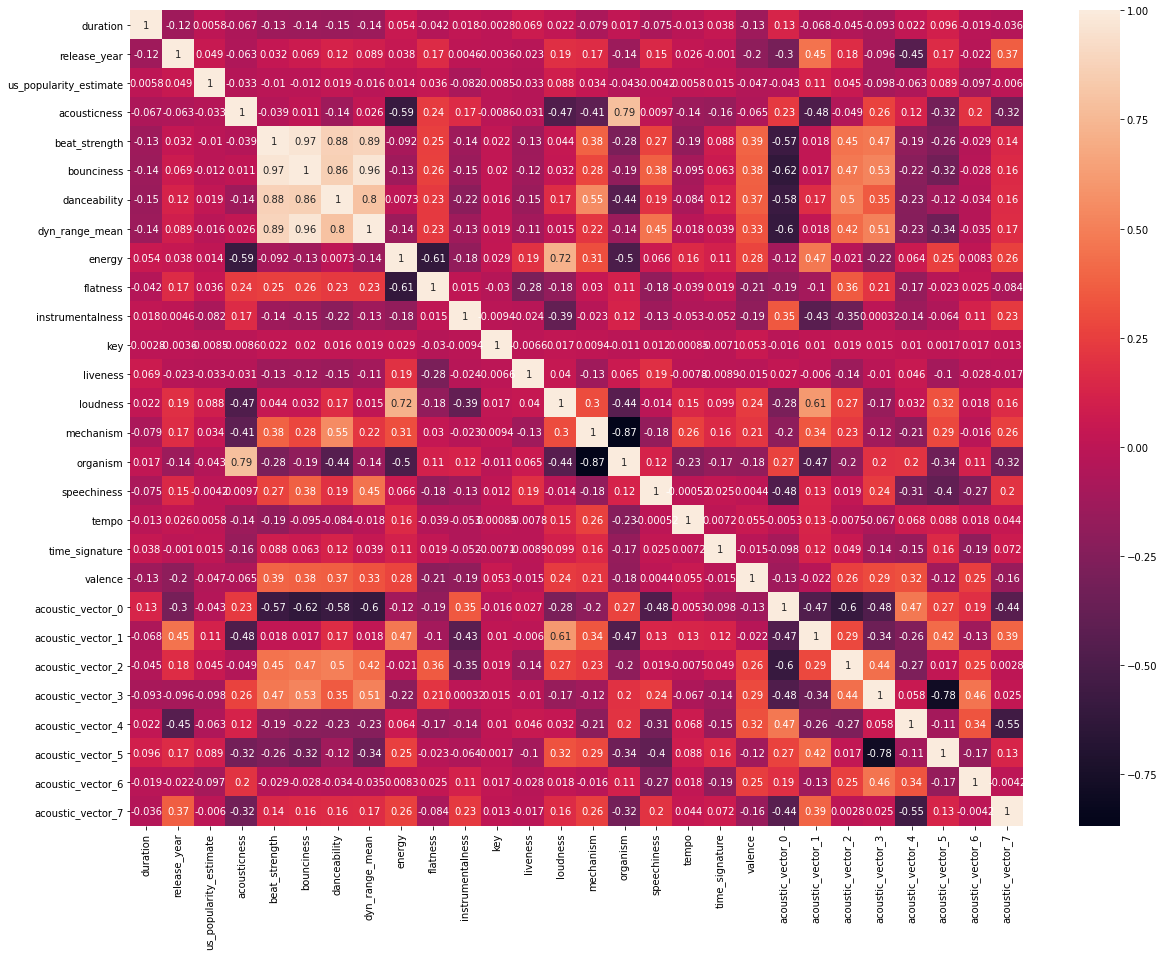

In [91]:
plt.figure(figsize=(20,15))
sns.heatmap(tf.corr(), annot=True);

### Merging track and Training Data on the basis of track_id (primary key):

In [92]:
track.shape

(101408, 30)

In [93]:
df.shape

(167880, 17)

In [94]:
df.rename(columns={'track_id_clean': 'track_id'}, inplace=True)

In [95]:
final_train = pd.merge(df, track, on=['track_id'], left_index=True, right_index=False, sort=True)
final_train.shape

(335760, 46)

In [97]:
final_train.sort_values(axis=0, by=['session_id','session_position'], inplace=True)
final_train.reset_index(drop=True,inplace=True)

In [98]:
final_train.head()

,session_id,session_position,session_length,track_id,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,skip,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,1,16,1,editorial_playlist,trackdone,trackdone,0,180.066666,2018,99.968133,0.015848,0.438551,0.473455,0.653119,7.660024,0.553465,1.035007,3.484468e-03,1,0.678553,-6.577,0.546784,1,0.320668,0.069717,134.024994,4,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,1,16,1,editorial_playlist,trackdone,trackdone,0,180.066666,2018,99.968133,0.015848,0.438551,0.473455,0.653119,7.660024,0.553465,1.035007,3.484468e-03,1,0.678553,-6.577,0.546784,1,0.320668,0.069717,134.024994,4,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,0,1,0,0,0,0,1,16,1,editorial_playlist,trackdone,trackdone,0,236.796371,2018,99.896728,0.061811,0.654804,0.735661,0.877393,11.308750,0.726828,1.025636,1.031315e-07,7,0.104322,-5.319,0.824766,0,0.131391,0.061158,130.037994,4,0.337152,-0.713646,0.363718,0.310315,-0.042222,-0.383164,0.066357,-0.365308,0.157920
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,0,1,0,0,0,0,1,16,1,editorial_playlist,trackdone,trackdone,0,236.796371,2018,99.896728,0.061811,0.654804,0.735661,0.877393,11.308750,0.726828,1.025636,1.031315e-07,7,0.104322,-5.319,0.824766,0,0.131391,0.061158,130.037994,4,0.337152,-0.713646,0.363718,0.310315,-0.042222,-0.383164,0.066357,-0.365308,0.157920
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,0,1,0,0,0,0,1,16,1,editorial_playlist,trackdone,trackdone,0,231.266663,2018,99.999976,0.354116,0.532155,0.540411,0.679719,8.065802,0.563009,1.029465,2.659035e-08,10,0.135776,-5.843,0.774327,1,0.296923,0.045354,145.028000,4,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604


In [99]:
ft = final_train.drop(columns=["session_id","track_id","key", 'time_signature'])
ft = pd.get_dummies(ft, drop_first=True)
ft.shape

(335760, 58)

In [100]:
ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335760 entries, 0 to 335759
Data columns (total 58 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   session_position                            335760 non-null  int64  
 1   session_length                              335760 non-null  int64  
 2   context_switch                              335760 non-null  int64  
 3   no_pause_before_play                        335760 non-null  int64  
 4   short_pause_before_play                     335760 non-null  int64  
 5   long_pause_before_play                      335760 non-null  int64  
 6   hist_user_behavior_n_seekfwd                335760 non-null  int64  
 7   hist_user_behavior_n_seekback               335760 non-null  int64  
 8   hist_user_behavior_is_shuffle               335760 non-null  int64  
 9   hour_of_day                                 335760 non-null  int64  
 

### Modeling with only Training Data 

In [101]:
dummy_train.head(2)

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,premium,skip,context_type_catalog,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_end_backbtn,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone
0,1,20,0,0,0,0,0,0,1,16,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,2,20,0,1,0,0,0,0,1,16,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [102]:
dummy_train.shape

(167880, 34)

### Train Test Split 

In [103]:
X = dummy_train.drop(columns=["skip"])
y = dummy_train.skip

X_resampled, Y_resampled = SMOTE(sampling_strategy=1.0, random_state=2).fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [104]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, Y_resampled,
    test_size=0.2,
    random_state=2
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=2
)   

### Standardsing Data

In [105]:
scaler = StandardScaler()
sX_train = scaler.fit_transform(X_train)
sX_val = scaler.transform(X_val)
sX_test = scaler.transform(X_test)


# Applying LOgistic Regression
log = LogisticRegressionCV(
    cv=3
).fit(
    sX_train,
    y_train
)

print("Log Train score: %s" % log.score(sX_train,y_train))
print("Log Val score:   %s" % log.score(sX_val,y_val))
print("Log Test score:  %s" % log.score(sX_test,y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Log Train score: 0.9905129958006055
Log Val score:   0.9891459025084405
Log Test score:  0.9895533382441573


###  Applying Random Forest

In [106]:
rfc = RandomForestClassifier(
    n_estimators=100
).fit(
    X_train,
    y_train
)

print("RFC Train score: %s" % rfc.score(X_train,y_train))
print("RFC Val score:   %s" % rfc.score(X_val,y_val))
print("RFC Test score:  %s" % rfc.score(X_test,y_test))

RFC Train score: 0.9974120010603122
RFC Val score:   0.989676051229108
RFC Test score:  0.9900220987075604


### Feature selection with Boruta 

In [107]:
!pip install boruta
from boruta import BorutaPy

In [108]:
rf = RandomForestClassifier(random_state=1, n_estimators=100, max_depth=5)
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)   # initialize the boruta selector
boruta_selector.fit(np.array(sX_train), np.array(y_train))  

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	28
Tentative: 	1
Rejected: 	4
Iteration: 	9 / 100
Confirmed: 	28
Tentative: 	1
Rejected: 	4
Iteration: 	10 / 100
Confirmed: 	28
Tentative: 	1
Rejected: 	4
Iteration: 	11 / 100
Confirmed: 	28
Tentative: 	1
Rejected: 	4
Iteration: 	12 / 100
Confirmed: 	28
Tentative: 	1
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	28
Tentative: 	1
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	28
Tentative: 	1
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	28
Tentative: 	1
Rejected: 	4
Iteration: 	16 / 100
Confirmed: 	28
Tentative: 	1
Rejected: 	4
I

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight=None, criterion='gini',
                                          max_depth=5, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=152, n_jobs=None,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x7F43705BFDB0,
                                          verbose=0, warm_start=False),
         max_iter=100, n_estimators='a

In [116]:
print("Selected Features: ", boruta_selector.support_)    # check selected features
print("Ranking: ",boruta_selector.ranking_)               # check ranking of features
print("No. of significant features: ", boruta_selector.n_features_)

Selected Features:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True False  True False  True
  True False  True False  True  True  True  True  True]
Ranking:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 3 1 4 1 1 5 1 6 1 1 1 1 1]
No. of significant features:  28


In [117]:
selected_rf_features = pd.DataFrame({'Feature':list(X.columns),
                                      'Ranking':boruta_selector.ranking_})
selected_rf_features.sort_values(by='Ranking')

,Feature,Ranking
0,session_position,1
30,hist_user_behavior_reason_end_logout,1
29,hist_user_behavior_reason_end_fwdbtn,1
28,hist_user_behavior_reason_end_endplay,1
26,hist_user_behavior_reason_end_backbtn,1
24,hist_user_behavior_reason_start_trackdone,1
23,hist_user_behavior_reason_start_remote,1
21,hist_user_behavior_reason_start_fwdbtn,1
19,hist_user_behavior_reason_start_clickrow,1
18,hist_user_behavior_reason_start_backbtn,1


In [118]:
X_important_train = boruta_selector.transform(np.array(X_train))
X_important_val = boruta_selector.transform(np.array(X_val))
X_important_test = boruta_selector.transform(np.array(X_test))

### Creating model selected by boruta

In [120]:
rf_important = RandomForestClassifier(random_state=1, n_estimators=100, n_jobs = -1)
rf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [121]:
print("RFC Train score: %s" % rf_important.score(X_important_train, y_train))
print("RFC Val score:   %s" % rf_important.score(X_important_val, y_val))
print("RFC Test score:  %s" % rf_important.score(X_important_test, y_test)) 

RFC Train score: 0.9974050253219303
RFC Val score:   0.9893412204581601
RFC Test score:  0.9901337083417041


### XG Boost

In [122]:
xg = xgb.XGBClassifier()
xg.fit(X_important_train, y_train,
       eval_set=[(X_important_train, y_train),(X_important_val, y_val)],
       early_stopping_rounds=10, verbose=True)   

[0]	validation_0-error:0.009975	validation_1-error:0.011384
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.009864	validation_1-error:0.011496
[2]	validation_0-error:0.009864	validation_1-error:0.011496
[3]	validation_0-error:0.009864	validation_1-error:0.011496
[4]	validation_0-error:0.009773	validation_1-error:0.011384
[5]	validation_0-error:0.00978	validation_1-error:0.011384
[6]	validation_0-error:0.009731	validation_1-error:0.011356
[7]	validation_0-error:0.009766	validation_1-error:0.011356
[8]	validation_0-error:0.009766	validation_1-error:0.011356
[9]	validation_0-error:0.009794	validation_1-error:0.011077
[10]	validation_0-error:0.009808	validation_1-error:0.011077
[11]	validation_0-error:0.009808	validation_1-error:0.011077
[12]	validation_0-error:0.009808	validation_1-error:0.011077
[13]	validation_0-error:0.009808	validation_1-error:0.011

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [123]:
print("XGB Train score: %s" % xg.score(X_important_train,y_train))
print("XGB Val score:   %s" % xg.score(X_important_val,y_val))
print("XGB Test score:  %s" % xg.score(X_important_test,y_test))

XGB Train score: 0.9902060633118015
XGB Val score:   0.9889226819944753
XGB Test score:  0.9891068997075828


### LGBM 

In [125]:
lgbm = LGBMClassifier( ).fit( X_important_train, y_train,
       eval_set=[(X_important_train, y_train),(X_important_val, y_val)],
       early_stopping_rounds=10, verbose=True)

print()
print("LGBM Train score: %s" % lgbm.score(X_important_train,y_train))
print("LGBM Val score:   %s" % lgbm.score(X_important_val,y_val))
print("LGBM Test score:  %s" % lgbm.score(X_important_test,y_test))

[1]	training's binary_logloss: 0.600908	valid_1's binary_logloss: 0.601237
Training until validation scores don't improve for 10 rounds.
[2]	training's binary_logloss: 0.525632	valid_1's binary_logloss: 0.526301
[3]	training's binary_logloss: 0.462638	valid_1's binary_logloss: 0.463584
[4]	training's binary_logloss: 0.409434	valid_1's binary_logloss: 0.41064
[5]	training's binary_logloss: 0.364231	valid_1's binary_logloss: 0.365685
[6]	training's binary_logloss: 0.325174	valid_1's binary_logloss: 0.32686
[7]	training's binary_logloss: 0.291528	valid_1's binary_logloss: 0.293457
[8]	training's binary_logloss: 0.262072	valid_1's binary_logloss: 0.26423
[9]	training's binary_logloss: 0.236324	valid_1's binary_logloss: 0.238688
[10]	training's binary_logloss: 0.21386	valid_1's binary_logloss: 0.216426
[11]	training's binary_logloss: 0.19395	valid_1's binary_logloss: 0.196712
[12]	training's binary_logloss: 0.17637	valid_1's binary_logloss: 0.179317
[13]	training's binary_logloss: 0.160822	

In [127]:
y_pred = lgbm.predict(X_important_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     22340
           1       1.00      0.99      0.99     22459

    accuracy                           0.99     44799
   macro avg       0.99      0.99      0.99     44799
weighted avg       0.99      0.99      0.99     44799



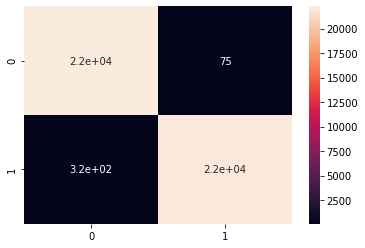

In [129]:
# draw classification report and confusion matrix  for LGBM MODEL (BASE MODEL)
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True)

In [130]:
import pickle
pickle.dump(lgbm, open("/content/drive/MyDrive/Spotify/data/llbm.pkl", 'wb'))
pickle.dump(xg, open("/content/drive/MyDrive/Spotify/data/xgb.pkl", 'wb'))
pickle.dump(rf_important, open("/content/drive/MyDrive/Spotify/data/rf.pkl", 'wb'))